## POS tagging using modified Viterbi

### Data Preparation

In [85]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs

In [86]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [87]:
# samples: Each sentence is a list of (word, pos) tuples
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [88]:
# converting the list of sents to a list of (word, pos tag) tuples
tagged_words = [tup for sent in nltk_data for tup in sent]
print(len(tagged_words))
tagged_words[:10]

100676


[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET')]

#### Splitting into Train and Test Sets

In [89]:
#set the random seed
random.seed(1234)

#Divide the data into training and test sets
train_set, test_set = train_test_split(nltk_data,test_size=0.05,random_state=99)

#Get the length of training and test sets
print(len(train_set))
print(len(test_set))

3718
196


In [90]:
test_set

[[('Three', 'NUM'),
  ('divisions', 'NOUN'),
  ('at', 'ADP'),
  ('American', 'NOUN'),
  ('Express', 'NOUN'),
  ('*ICH*-1', 'X'),
  ('are', 'VERB'),
  ('working', 'VERB'),
  ('with', 'ADP'),
  ('Buick', 'NOUN'),
  ('on', 'ADP'),
  ('the', 'DET'),
  ('promotion', 'NOUN'),
  (':', '.'),
  ('the', 'DET'),
  ('establishment', 'NOUN'),
  ('services', 'NOUN'),
  ('division', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('*T*-57', 'X'),
  ('is', 'VERB'),
  ('responsible', 'ADJ'),
  ('for', 'ADP'),
  ('all', 'DET'),
  ('merchants', 'NOUN'),
  ('and', 'CONJ'),
  ('companies', 'NOUN'),
  ('that', 'DET'),
  ('*T*-2', 'X'),
  ('accept', 'VERB'),
  ('the', 'DET'),
  ('card', 'NOUN'),
  (';', '.'),
  ('the', 'DET'),
  ('travel', 'NOUN'),
  ('division', 'NOUN'),
  (';', '.'),
  ('and', 'CONJ'),
  ('the', 'DET'),
  ('merchandise', 'NOUN'),
  ('sales', 'NOUN'),
  ('division', 'NOUN'),
  ('.', '.')],
 [('W.R.', 'NOUN'),
  ('Grace', 'NOUN'),
  ('holds', 'VERB'),
  ('three', 'NUM'),
  ('of', 'ADP'),
  ('Gr

In [91]:
# Getting list of tagged words
tagged_words = [tup for sent in train_set for tup in sent]
#length of the tagged words in training set
len(tagged_words)

95779

In [92]:
# View the first 10 tokens/words in the training set
tokens = [pair[0] for pair in tagged_words]
tokens[:10]

['It',
 'also',
 'empowers',
 'the',
 'president',
 'to',
 'make',
 'recess',
 'appointments',
 ',']

In [93]:
# vocabulary
V = set(tokens)
print(len(V))

12080


In [94]:
# number of pos tags in the training corpus
T = list(set([pair[1] for pair in tagged_words]))


In [95]:
print(len(T))


12


In [96]:
print(T)

['ADP', 'NOUN', 'PRT', 'PRON', 'CONJ', 'NUM', 'VERB', 'ADV', 'X', 'ADJ', '.', 'DET']


There are 12 tags which are part of universal tagset

### Build the vanilla Viterbi based POS tagger

#### Emission Probabilities

In [97]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [98]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transition Probabilities

In [99]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [100]:
# creating t x t (pos tags x pos tags)transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [101]:
tags_matrix

array([[1.66116487e-02, 3.22329879e-01, 1.38430414e-03, 6.88957497e-02,
        9.58364399e-04, 6.27196282e-02, 8.30582436e-03, 1.38430409e-02,
        3.43946330e-02, 1.06271960e-01, 4.01448198e-02, 3.24140131e-01],
       [1.76731661e-01, 2.64151633e-01, 4.39464487e-02, 4.76571592e-03,
        4.26367857e-02, 9.34953429e-03, 1.47373393e-01, 1.70256104e-02,
        2.85215359e-02, 1.22598950e-02, 2.40286663e-01, 1.29511058e-02],
       [2.00131238e-02, 2.48687670e-01, 1.64041994e-03, 1.73884518e-02,
        2.29658792e-03, 5.70866130e-02, 3.96981627e-01, 9.84251965e-03,
        1.41076120e-02, 8.59580040e-02, 4.39632535e-02, 1.02034122e-01],
       [2.22052075e-02, 2.08269522e-01, 1.22511489e-02, 8.03981628e-03,
        5.35987737e-03, 7.27411965e-03, 4.86600310e-01, 3.48392054e-02,
        9.26493108e-02, 7.35068917e-02, 4.01990823e-02, 8.80551338e-03],
       [5.38783111e-02, 3.50673467e-01, 5.10914996e-03, 5.94519265e-02,
        4.64468176e-04, 4.22666036e-02, 1.56525776e-01, 5.34

In [102]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,ADP,NOUN,PRT,PRON,CONJ,NUM,VERB,ADV,X,ADJ,.,DET
ADP,0.016612,0.322330,0.001384,0.068896,0.000958,0.062720,0.008306,0.013843,0.034395,0.106272,0.040145,0.324140
NOUN,0.176732,0.264152,0.043946,0.004766,0.042637,0.009350,0.147373,0.017026,0.028522,0.012260,0.240287,0.012951
PRT,0.020013,0.248688,0.001640,0.017388,0.002297,0.057087,0.396982,0.009843,0.014108,0.085958,0.043963,0.102034
PRON,0.022205,0.208270,0.012251,0.008040,0.005360,0.007274,0.486600,0.034839,0.092649,0.073507,0.040199,0.008806
CONJ,0.053878,0.350673,0.005109,0.059452,0.000464,0.042267,0.156526,0.053414,0.008360,0.116582,0.035300,0.117975
NUM,0.035419,0.352420,0.027155,0.001476,0.012987,0.185950,0.017710,0.002952,0.212515,0.032763,0.114817,0.003837
VERB,0.091311,0.110628,0.031652,0.035376,0.005198,0.023119,0.169589,0.081691,0.217067,0.064856,0.035376,0.134135
ADV,0.119348,0.031582,0.013963,0.014628,0.006649,0.031915,0.345745,0.078790,0.023936,0.129654,0.135306,0.068484
X,0.146299,0.062540,0.182833,0.055680,0.010370,0.002712,0.204371,0.025367,0.074665,0.017071,0.162891,0.055201
ADJ,0.077087,0.700180,0.010333,0.000656,0.016894,0.020666,0.011645,0.004756,0.020502,0.067082,0.065770,0.004428


In [103]:
tags_df.loc['.', :]

ADP     0.091593
NOUN    0.222710
PRT     0.002330
PRON    0.066768
CONJ    0.057985
NUM     0.081197
VERB    0.088009
ADV     0.052160
X       0.027066
ADJ     0.044721
.       0.093207
DET     0.172163
Name: ., dtype: float32

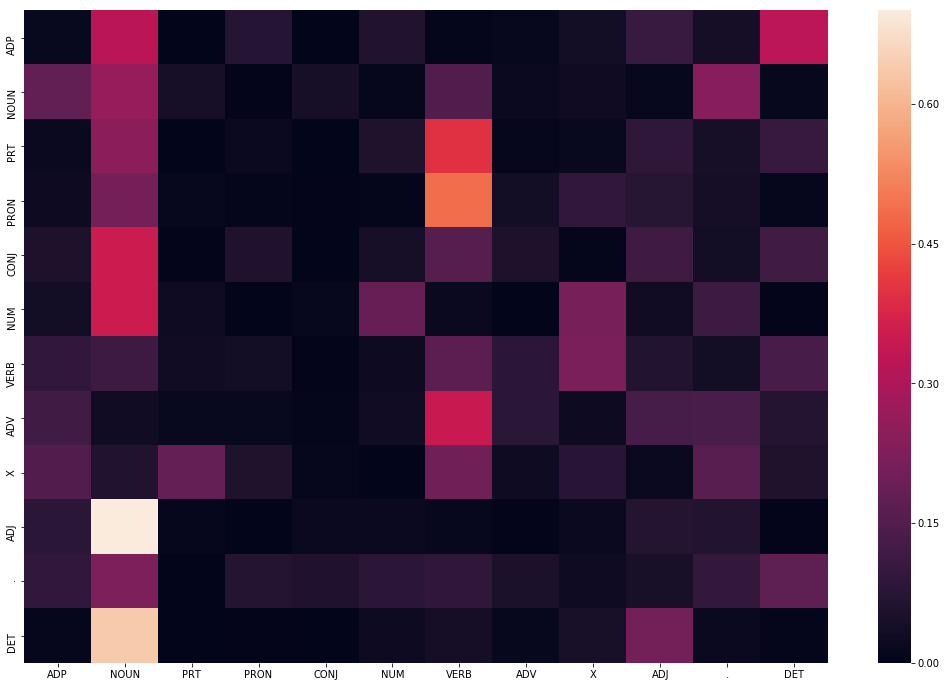

In [104]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

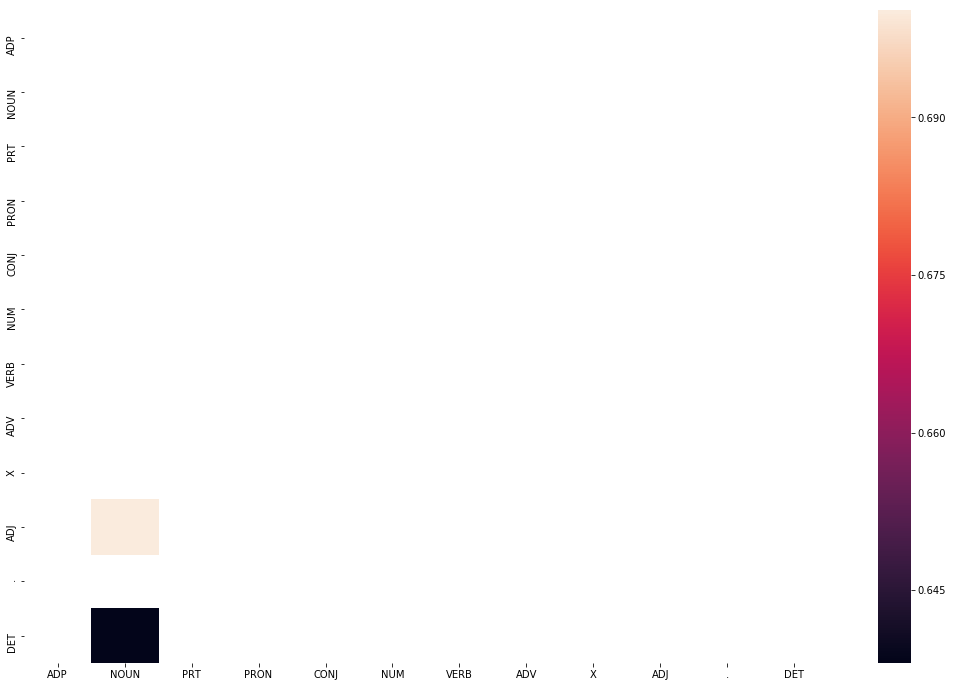

In [105]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

NOUN and DET & NOUN and ADJ are highly correlated. Most often nouns are followed by adjectives and determinants

#### Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [106]:
#Get the total length of tagged words in training corpus
len(tagged_words)

95779

In [107]:
# Viterbi Heuristic
def Viterbi(words, train_bag = tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating on Test Set

In [108]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]


In [109]:
test_run

[[('Mr.', 'NOUN'),
  ('Bush', 'NOUN'),
  ('has', 'VERB'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('he', 'PRON'),
  ('would', 'VERB'),
  ('like', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('be', 'VERB'),
  ('able', 'ADJ'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('use', 'VERB'),
  ('this', 'DET'),
  ('procedure', 'NOUN'),
  ('.', '.')],
 [('-LRB-', '.'),
  ('This', 'DET'),
  ('*ICH*-1', 'X'),
  ('clearly', 'ADV'),
  ('is', 'VERB'),
  ('not', 'ADV'),
  ('real', 'ADJ'),
  ('life', 'NOUN'),
  (':', '.'),
  ('no', 'DET'),
  ('crack', 'NOUN'),
  ('dealers', 'NOUN'),
  (',', '.'),
  ('no', 'DET'),
  ('dead-eyed', 'ADJ'),
  ('men', 'NOUN'),
  ('selling', 'VERB'),
  ('four-year-old', 'ADJ'),
  ('copies', 'NOUN'),
  ('of', 'ADP'),
  ('Cosmopolitan', 'NOUN'),
  (',', '.'),
  ('no', 'DET'),
  ('one', 'PRON'),
  ('curled', 'VERB'),
  ('up', 'PRT'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('cardboard', 'NOUN'),
  ('box', 'NOUN'),
  ('.', '.'),
  ('-RRB-', '.')],
 [('In', 'ADP'),
  ('addition', 'NOUN'),
  ('to'

In [110]:
test_run_base

[('Mr.', 'NOUN'),
 ('Bush', 'NOUN'),
 ('has', 'VERB'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('he', 'PRON'),
 ('would', 'VERB'),
 ('like', 'VERB'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('be', 'VERB'),
 ('able', 'ADJ'),
 ('*-2', 'X'),
 ('to', 'PRT'),
 ('use', 'VERB'),
 ('this', 'DET'),
 ('procedure', 'NOUN'),
 ('.', '.'),
 ('-LRB-', '.'),
 ('This', 'DET'),
 ('*ICH*-1', 'X'),
 ('clearly', 'ADV'),
 ('is', 'VERB'),
 ('not', 'ADV'),
 ('real', 'ADJ'),
 ('life', 'NOUN'),
 (':', '.'),
 ('no', 'DET'),
 ('crack', 'NOUN'),
 ('dealers', 'NOUN'),
 (',', '.'),
 ('no', 'DET'),
 ('dead-eyed', 'ADJ'),
 ('men', 'NOUN'),
 ('selling', 'VERB'),
 ('four-year-old', 'ADJ'),
 ('copies', 'NOUN'),
 ('of', 'ADP'),
 ('Cosmopolitan', 'NOUN'),
 (',', '.'),
 ('no', 'DET'),
 ('one', 'PRON'),
 ('curled', 'VERB'),
 ('up', 'PRT'),
 ('in', 'ADP'),
 ('a', 'DET'),
 ('cardboard', 'NOUN'),
 ('box', 'NOUN'),
 ('.', '.'),
 ('-RRB-', '.'),
 ('In', 'ADP'),
 ('addition', 'NOUN'),
 ('to', 'PRT'),
 ('the', 'DET'),
 ('extra', 'ADJ'),
 ('privac

In [111]:
test_tagged_words

['Mr.',
 'Bush',
 'has',
 'said',
 '0',
 'he',
 'would',
 'like',
 '*-1',
 'to',
 'be',
 'able',
 '*-2',
 'to',
 'use',
 'this',
 'procedure',
 '.',
 '-LRB-',
 'This',
 '*ICH*-1',
 'clearly',
 'is',
 'not',
 'real',
 'life',
 ':',
 'no',
 'crack',
 'dealers',
 ',',
 'no',
 'dead-eyed',
 'men',
 'selling',
 'four-year-old',
 'copies',
 'of',
 'Cosmopolitan',
 ',',
 'no',
 'one',
 'curled',
 'up',
 'in',
 'a',
 'cardboard',
 'box',
 '.',
 '-RRB-',
 'In',
 'addition',
 'to',
 'the',
 'extra',
 'privacy',
 'of',
 'these',
 'trades',
 ',',
 'the',
 'transactions',
 'can',
 'often',
 'be',
 'less',
 'expensive',
 '*',
 'to',
 'execute',
 ',',
 'because',
 'the',
 'parties',
 'do',
 "n't",
 'have',
 '*-1',
 'to',
 'pay',
 'a',
 'floor',
 'brokerage',
 'fee',
 'or',
 'a',
 'specialist',
 "'s",
 'fee',
 '.',
 'The',
 'Constitution',
 'does',
 'not',
 'expressly',
 'give',
 'the',
 'president',
 'such',
 'power',
 '.',
 'The',
 'Treasury',
 'plans',
 '*-1',
 'to',
 'sell',
 '$',
 '30',
 'billion

In [112]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [113]:
#Print total time taken to train the algorithm
print(difference)

32.694157123565674


In [114]:
# Get accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_vanilla = len(check)/len(tagged_seq)
print("Accuracy of Vanilla Viterbi Algorithm :",accuracy_vanilla)

Accuracy of Vanilla Viterbi Algorithm : 0.9230769230769231


We get around 92% of accuracy with the default Viterbi algorithm.

Let's compare with the test sentences and see how it tagged the sentences

### Solve the problem of unknown words

In [115]:
#Read the text file
sentences_test=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for sentence in f:
    print(sentence)
    sentences_test.append(sentence)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

In [116]:
sentences_test

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [117]:
#Strip the special characters and empty strings in the list file
sentences =[sent.rstrip() for sent in sentences_test if sent.rstrip()!='']
sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [118]:
#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('would', 'VERB'), (('like', 'ADP'), ('like', 'VERB'))],
 [('no', 'DET'), (('crack', 'VERB'), ('crack', 'NOUN'))],
 [('no', 'DET'), (('dead-eyed', 'ADP'), ('dead-eyed', 'ADJ'))],
 [('selling', 'VERB'), (('four-year-old', 'ADP'), ('four-year-old', 'ADJ'))],
 [('of', 'ADP'), (('Cosmopolitan', 'ADP'), ('Cosmopolitan', 'NOUN'))],
 [('no', 'DET'), (('one', 'NUM'), ('one', 'PRON'))],
 [('one', 'PRON'), (('curled', 'ADP'), ('curled', 'VERB'))],
 [('curled', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('be', 'VERB'), (('less', 'ADJ'), ('less', 'ADV'))],
 [('not', 'ADV'), (('expressly', 'ADP'), ('expressly', 'ADV'))]]

In [119]:
#Most of the words which are not present in training set are simply assigned the first pos tag in the training pos tagset

#Let us do the analysis on the sample test file as well

In [120]:
#Get the predictions on the test file
pred_list =[]
for line in sentences:
    pred_list=pred_list+list(Viterbi(word_tokenize(line)))
pred_list

[('Android', 'ADP'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADP'),
 ('.', '.'),
 ('Android', 'ADP'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADP'),
 ('worldwide', 'ADP'),
 ('on', 'ADP'),
 ('smartphones', 'ADP'),
 ('since', 'ADP'),
 ('2011', 'ADP'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'ADP'),
 ('.', '.'),
 ('Google', 'ADP'),
 ('and', 'CONJ'),
 ('Twitter', 'ADP'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADP'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'ADP'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'ADP'),
 ("'s", 'PRT'),
 ('firehose', 'ADP'),
 ('.', '.'),
 ('Twitter', 'ADP'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADP'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'ADP'),
 ('service', 'NOUN

Words like 'Android','Google' the first tag in the training pos tagset is given. Let us see if these words exist in the training corpus 

In [121]:
#Get the tokens in the test file
words=[tokens for sentence in sentences for tokens in word_tokenize(sentence)]
print(words)


['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 'Twitter', "'s", 'firehose', '.', 'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.', 'Before', 'entering', 'politics', ',', 'Donald', 'Trump', 'was', 'a', 'domineering', 'businessman', 'and', 'a', 'television', 'personality', '.', 'The', '2018', 'FIFA', 'World', 'Cup', 'is', 'the', '21st', 'FIFA', 'World', 'Cup', ',', 'an', 'international', 'football', 'tournament', 'contested', 'once', 'every', 'four', 'years', '.', 'This', 'is', 'the', 'first', 'World', 'Cup', 'to', 'be', 'held', 'in', 'Eastern', 'Europe', 'and',

In [122]:
#Get the list of words which are present in test lines but not in the training corpus
unknown_words = list(set(words) - set(tokens))
unknown_words

['NASA',
 'ICESAT-2',
 'arriving',
 '21st',
 'OS',
 '2011',
 'contested',
 'Google',
 'smartphones',
 'tournament',
 '2015',
 'FIFA',
 'Twitter',
 'firehose',
 'trips',
 'worldwide',
 'interact',
 'personality',
 '2013',
 'Satellite',
 'Cup',
 'networking',
 'online',
 'Android',
 '2018',
 'domineering',
 'messages',
 'tweets',
 'invited']

We can clearly seen words Twitter,FIFA,Android, Google etc are not in corpus 

In [123]:
#Get the tags predicted for unknown words
words_untag=[tup for tup in pred_list for word in unknown_words if tup[0]==word ]
print(words_untag)

[('Android', 'ADP'), ('Google', 'ADP'), ('Android', 'ADP'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('smartphones', 'ADP'), ('2011', 'ADP'), ('2013', 'ADP'), ('Google', 'ADP'), ('Twitter', 'ADP'), ('2015', 'ADP'), ('Google', 'ADP'), ('Twitter', 'ADP'), ('firehose', 'ADP'), ('Twitter', 'ADP'), ('online', 'ADP'), ('networking', 'ADP'), ('interact', 'ADP'), ('messages', 'ADP'), ('tweets', 'ADP'), ('domineering', 'ADP'), ('personality', 'ADP'), ('2018', 'ADP'), ('FIFA', 'ADP'), ('Cup', 'ADP'), ('21st', 'ADP'), ('FIFA', 'ADP'), ('Cup', 'ADP'), ('tournament', 'ADP'), ('contested', 'ADP'), ('Cup', 'ADP'), ('trips', 'ADP'), ('arriving', 'ADP'), ('NASA', 'ADP'), ('invited', 'ADP'), ('ICESAT-2', 'ADP'), ('Satellite', 'ADP')]


In [124]:
#count of all tags in the training set..to count the frequency of elements in a list, the Counter() class from collections

from collections import Counter
tags = [pair[1] for pair in tagged_words]
#tags = [pair[1] for pair in words]
tag_counts = Counter(tags)
tag_counts

Counter({'PRON': 2612,
         'ADV': 3008,
         'VERB': 12890,
         'DET': 8278,
         'NOUN': 27488,
         'PRT': 3048,
         '.': 11158,
         'ADP': 9391,
         'X': 6268,
         'ADJ': 6097,
         'CONJ': 2153,
         'NUM': 3388})

In [125]:
# the most common tags can be seen using the most_common() method of Counter
tag_counts.most_common(5)

[('NOUN', 27488), ('VERB', 12890), ('.', 11158), ('ADP', 9391), ('DET', 8278)]

Thus, NOUN is the most common tag followed by VERB, ., ADP, DET , etc 

In [126]:
#Lets see count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'ADP': 6, 'VERB': 1, 'NUM': 1, 'ADV': 1, 'ADJ': 1})

##### Lets do some EDA

In [127]:
# The percentage of verbs which end with 'ed'
past_tense_verbs = [pair for pair in tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in past_tense_verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(past_tense_verbs))
ed_verbs[:20]

0.20512024825446082


[('diluted', 'VERB'),
 ('adjusted', 'VERB'),
 ('declared', 'VERB'),
 ('fared', 'VERB'),
 ('shipped', 'VERB'),
 ('posted', 'VERB'),
 ('plummeted', 'VERB'),
 ('surrendered', 'VERB'),
 ('increased', 'VERB'),
 ('led', 'VERB'),
 ('opposed', 'VERB'),
 ('construed', 'VERB'),
 ('promised', 'VERB'),
 ('rejected', 'VERB'),
 ('denied', 'VERB'),
 ('priced', 'VERB'),
 ('estimated', 'VERB'),
 ('auctioned', 'VERB'),
 ('voted', 'VERB'),
 ('listed', 'VERB')]

 Around 21% of words which end with 'ed' are verbs. It is high because this is universal tagset and Verbs contain all the forms of verbs

In [128]:
# Let us see the percentage of verbs which are classifed as 'verb which end with 'ing'
participle_verbs = [pair for pair in tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in participle_verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(participle_verbs))
ing_verbs[:20]

0.1091543832428239


[('granting', 'VERB'),
 ('earning', 'VERB'),
 ('beginning', 'VERB'),
 ('reaching', 'VERB'),
 ('saying', 'VERB'),
 ('hugging', 'VERB'),
 ('using', 'VERB'),
 ('exerting', 'VERB'),
 ('showing', 'VERB'),
 ('rising', 'VERB'),
 ('being', 'VERB'),
 ('funding', 'VERB'),
 ('according', 'VERB'),
 ('plunging', 'VERB'),
 ('varying', 'VERB'),
 ('altering', 'VERB'),
 ('easing', 'VERB'),
 ('yielding', 'VERB'),
 ('paying', 'VERB'),
 ('slowing', 'VERB')]

 Around 11% of words which end with 'ing' are verbs.

In [129]:
#Lets see percentage of Adjective tags followed by nouns
# create a list of all tags (without the words)
tags = [pair[1] for pair in tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_nn_tags) / len(adj_tags))

0.7001804165983271


Around 70% of adjectives are followed by Nouns

In [130]:
#Lets see percentage of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_nn_tags) / len(dt_tags))

0.6380768301522107


Around 64% of determinants are followed by Nouns

In [131]:
#Lets see percentage of Adverbs tags followed by Verbs
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_vb_tags) / len(adv_tags))

0.34574468085106386


Around 35% of adverbs are followed by verbs

#### Evaluating tagging accuracy

###### Lexicon (Unigram) Tagger
Let's now try training a lexicon (or a unigram) tagger which assigns the most commonly assigned tag to a word.

In NLTK, the UnigramTagger() can be used to train such a model.

In [132]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger.evaluate(test_set)


0.9032060445170512

###### Rule-Based (Regular Expression) Tagger

Now let's build a rule-based, or regular expression based tagger. In NLTK, the `RegexpTagger()` can be provided with handwritten regular expression patterns, as shown below.


In [133]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [134]:
regexp_tagger = nltk.RegexpTagger(patterns)

In [135]:
regexp_tagger.evaluate(test_set)


0.41127220747396365

###### Combining Taggers

Let's now try combining the taggers created above. We saw that the rule-based tagger by itself is quite ineffective since we've only written a handful of rules. However, if we could combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

NLTK provides a convenient way to combine taggers using the 'backup' argument. In the following code, we create a regex tagger which is used as a backup tagger to the lexicon tagger, i.e. when the tagger is not able to tag using the lexicon (in case of a new word not in the vocabulary), it uses the rule-based tagger. 



In [136]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

lexicon_tagger.evaluate(test_set)


0.9497651623442924

For a Unigram lexicon tagger backed up by a rule based tagger the accuracy is around 94.9%. Let us improve it further by using N-gram taggers

In [137]:
#Trigram tagger backed by Bigram backed by Unigram/Lexicon
Bigram_tagger = nltk.BigramTagger(train_set, backoff=lexicon_tagger)
Trigram_Tagger = nltk.TrigramTagger(train_set, backoff=Bigram_tagger)

In [138]:
Trigram_Tagger.evaluate(test_set)


0.9516030222585257

The state probabilities for unknown words become zero and hence the Viterbi algorithm updates the unknown words by default with the first tag in the training set.

Now lets modify the Viterbi algorithm such that when the state probabilities become zero it updates the tag based on the tagger we created above

###### Modified Viterbi Heuristic using Rule based/Regular expression Tagger

In [139]:
# Modified Viterbi Heuristic using Rule based/Regular expression Tagger
def Mod_Viterbi_regex(words, train_bag = tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the trigram tagger
            state_max = regexp_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

###### Modified Viterbi Heuristic using combined Tagger

In [140]:
# Modified Viterbi Heuristic using combine Tagger
def Mod_Viterbi_combine(words, train_bag = tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the trigram tagger
            state_max = lexicon_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

###### Modified Viterbi Heuristic using trigram Tagger

In [141]:
# Modified Viterbi Heuristic using trigram tagger
def Mod_Viterbi_tri(words, train_bag = tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the trigram tagger
            state_max = Trigram_Tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

###### Use Brill algorithm(Transformation-Based Tagging) as a base algorithm backed by the tagger created above

In [142]:
import nltk.tag
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

Template._cleartemplates()
templates = fntbl37()
trainer = BrillTaggerTrainer(Trigram_Tagger, templates, trace=3)
tagger = trainer.train(train_set, max_rules=250)

TBL train (fast) (seqs: 3718; tokens: 95779; tpls: 37; min score: 2; min acc: None)
Finding initial useful rules...
    Found 21156 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
  53  58   5   0  | DET->ADP if Word:that@[0] & Pos:NOUN@[2]
  29  29   0   0  | DET->ADP if Word:that@[0] & Pos:PRON@[1]
  26  27   1   0  | ADP->ADV if Word:as@[0] & Word:as@[2]
  15  18   3   0  | ADP->DET if Word:that@[0] & Pos:X@[1]
   9   9   0   0  | ADV->ADJ if Word:more@[0] & Pos:NOUN@[1]
   6   6   0   0  | DET->ADP if Word:that@[0] & Pos:DET@[1]
   6   7   1   0  | DET->ADV if Word:no@[0] & Pos:ADV@[1]
   5   5   0   0  | PRT->ADP if Word:out@[0] &

The state probabilities for unknown words become zero and hence the Viterbi algorithm updates the unknown words by default with the first tag in the training set.

Now lets modify the Viterbi algorithm such that when the state probabilities become zero it updates the tag based on the tagger we created above

In [143]:
# Viterbi Heuristic
def Mod_Viterbi_Brill(words, train_bag = tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Accuracy using Regular expression tagger

In [144]:
# tagging the test sentences with the modified Viterbi algorithm  --Regex tagger
start = time.time()
mod_tagged_seq_regex = Mod_Viterbi_regex(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

30.031307220458984


In [159]:
# Calculate the accuracy for the updated Viterbi algorithm -- Regex tagger
check = [i for i, j in zip(mod_tagged_seq_regex, test_run_base) if i == j] 
accuracy_regex = len(check)/len(mod_tagged_seq_regex)
print(accuracy_regex)

0.9461538461538461


In [160]:
print("Accuracy Of Vanilla Viterbi Algorithm     :: {0:.2%}".format(accuracy_vanilla))
print("Accuracy Of Modified Viterbi Regex tagger :: {0:.2%}".format(accuracy_regex))
#<b> Accuracy Of Vanilla Viterbi Algorithm :: 93%<br>
 #   Accuracy of Modified Viterbi using Regex tagger :: 95% </b>

Accuracy Of Vanilla Viterbi Algorithm     :: 92.31%
Accuracy Of Modified Viterbi Regex tagger :: 94.62%


Accuracy - using Combined tagger

In [161]:
# tagging the test sentences with the modified Viterbi algorithm  --combine tagger 
start = time.time()
mod_tagged_seq_combine = Mod_Viterbi_combine(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

31.161399364471436


In [162]:
# Calculate the accuracy for the updated Viterbi algorithm -- combine tagger
check = [i for i, j in zip(mod_tagged_seq_combine, test_run_base) if i == j] 
accuracy_combine = len(check)/len(mod_tagged_seq_combine)
print(accuracy_combine)

0.9461538461538461


In [163]:
print("Accuracy Of Vanilla Viterbi Algorithm     :: {0:.2%}".format(accuracy_vanilla))
print("Accuracy Of Modified Viterbi Combined tagger :: {0:.2%}".format(accuracy_combine))


Accuracy Of Vanilla Viterbi Algorithm     :: 92.31%
Accuracy Of Modified Viterbi Combined tagger :: 94.62%


Accuracy Using Trigram tagger

In [164]:
# tagging the test sentences with the modified Viterbi algorithm  --trigram tagger
start = time.time()
mod_tagged_seq_tri = Mod_Viterbi_tri(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

31.578466415405273


In [165]:
# Calculate the accuracy for the updated Viterbi algorithm -- trigram tagger
check = [i for i, j in zip(mod_tagged_seq_tri, test_run_base) if i == j] 
accuracy_tri = len(check)/len(mod_tagged_seq_tri)
print(accuracy_tri)

0.9461538461538461


In [167]:
print("Accuracy Of Vanilla Viterbi Algorithm       :: {0:.2%}".format(accuracy_vanilla))
print("Accuracy Of Modified Viterbi Trigram tagger :: {0:.2%}".format(accuracy_tri))


Accuracy Of Vanilla Viterbi Algorithm       :: 92.31%
Accuracy Of Modified Viterbi Trigram tagger :: 94.62%


In [168]:
# tagging the test sentences with the modified Viterbi algorithm --- Brill Tagger
start = time.time()
mod_tagged_seq_Brill = Mod_Viterbi_Brill(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

32.760404109954834


Accuracy -- using Brill Tagger

In [169]:
# Calculate the accuracy for the updated Viterbi algorithm  --- Brill Tagger
check = [i for i, j in zip(mod_tagged_seq_Brill, test_run_base) if i == j] 
accuracy_brill = len(check)/len(mod_tagged_seq_Brill)
accuracy_brill

0.9461538461538461

In [170]:
print("Accuracy Of Vanilla Viterbi Algorithm     :: {0:.2%}".format(accuracy_vanilla))
print("Accuracy Of Modified Viterbi Brill tagger :: {0:.2%}".format(accuracy_brill))

Accuracy Of Vanilla Viterbi Algorithm     :: 92.31%
Accuracy Of Modified Viterbi Brill tagger :: 94.62%


<b><font color="Blue"> ACCURACY INCREASED BY THE MODIFIED VITERBI ALGORITHM  </font> </b>

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [156]:
#Incorrectly tagged with the Vanilla Viterbi algorithm

for sentence in sentences:
    print(list(Viterbi(word_tokenize(sentence))))

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')]
[('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.')]
[('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose', 'ADP'), ('.', '.')]
[('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'ADP'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'N

In [157]:
# Correctly tagged Using Modified viterbi algorithm trigram

for sentence in sentences:
    print(list(Mod_Viterbi_tri(word_tokenize(sentence))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'VERB'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

In [158]:
# Correctly tagged words Using Modified viterbi algorithm Brill Technique

for sentence in sentences:
    print(list(Mod_Viterbi_Brill(word_tokenize(sentence))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'VERB'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

The following are some of the sentences corrected by the modified viterbi algorithm

##### 'Android is a mobile operating system developed by Google.'

Here 'Android', 'Google' are incorrectly tagged in the vanilla viterbi algorithm.With the modified Viterbi algorithm 'Android' and 'Google' are correctly classified as 'NOUN' though they are unknown words

###### 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

Here 'Android', 'OS',' worldwide' are incorrectly tagged in the vanilla viterbi algorithm. With the modified Viterbi algorithm those words are correctly classified as Nouns.

Also words like '2011','2013' are incorrectly classified with the vanilla algorithm. Because we used rule based tagger as backoff tagger and we have rule for indicating cardinal numbers '2011','2013' is correctly tagged as 'NUM' in the modified viterbi algorithm.

###### 'Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.'

Here 'Google','Twitter' and '2015' are incorrectly tagged in the vanilla viterbi algorithm. With the modified Viterbi algorithm 'Google','Twitter' are correctly classified as Nouns and '2015' correctly tagged as 'NUM'.

###### 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'

Here '2018','FIFA' , 'Cup','21st','tournament' are incorrectly tagged in the vanilla viterbi algorithm. With the modified Viterbi algorithm 'FIFA' , 'Cup','21st','tournament'are correctly classified as Nouns and '2018' correctly tagged as 'NUM' and 'contested' correctly tagged as 'VERB'.

 ##### 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'

Here 'NASA', 'ICESAT-2',' Satellite' are incorrectly tagged in the vanilla viterbi algorithm. With modified Viterbi algorithm those are correctly classified as 'NOUN' though they are unknown words.
